---
### Invert with regularization.
Please check the origional paper:\
[Felipe A. Bulat, Tim Heaton-Burgess, Aron J. Cohen, and Weitao Yang, J. Chem. Phys. 127, 174101 (2007)]\
[Tim Heaton-Burgess, Felipe A. Bulat, and Weitao Yang, PRL 98, 256401 (2007)]

In [25]:
import psi4
import matplotlib.pyplot as plt
import numpy as np

psi4.set_options({"save_jk" : True})
psi4.set_memory(int(2.50e9))
psi4.core.clean()

import n2v

In [2]:
Ne = psi4.geometry( 
""" 
0 1
Ne
noreorient
nocom
units bohr
symmetry c1
""" )

psi4.set_options({"reference" : "rhf"})  # Spin-Restricted

# IMPORTANT NOTE: psi4.energy does not update cc densities. So we calculate dipole momentes instead.
wfn = psi4.properties("ccsd/aug-cc-pvtz",  return_wfn=True, molecule=Ne, property=['dipole'])[1]

# Build inverter and set target
ine = n2v.Inverter(wfn, pbs="aug-cc-pvqz")

#### Result without regularization

In [3]:
# Inverter with WuYang method, guide potention v0=Fermi-Amaldi
ine.invert("WuYang", guide_potential_components=["fermi_amaldi"])

Optimization Successful within 9 iterations! |grad|=1.03e-06


In [4]:
x = np.linspace(-5,5,101)
y = np.zeros_like(x)
z = np.zeros_like(x)
grids = np.array([x,y,z])

vH, vFA = ine.on_grid_esp(grids=grids)[1:3]

vrest = ine.on_grid_ao(ine.v_opt, grids=grids, basis=ine.pbs)

vxc = vFA + vrest - vH

Accoding to the two paper I cited above,
$$
P(\lambda) = \lambda \frac{\|v_{rest}(\lambda)\|^2}{L^{\lambda=0}-L^{\lambda}},
$$
where $L$ is the Lagrangian.\
$T_s$ is the non-interacting kinetic energy.

In [5]:
lambda_list, P, Ts = ine.find_regularization_constant(guide_potential_components=["fermi_amaldi"], 
                                                      opt_method="trust-krylov",
                                                      lambda_list=10 ** np.linspace(-3,-9,21))

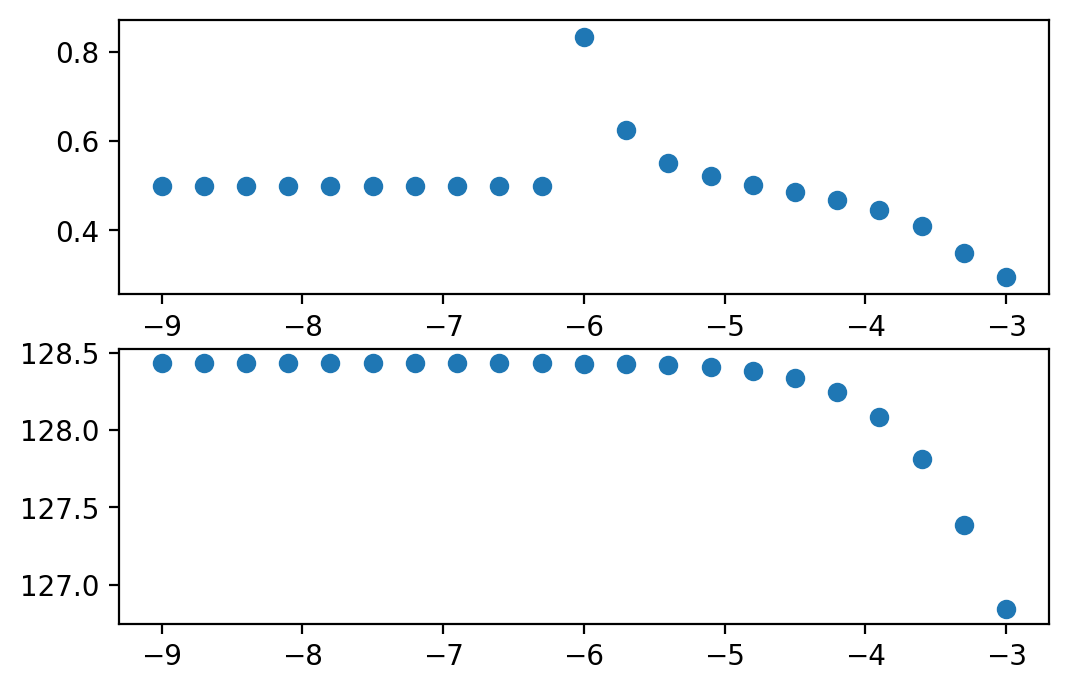

In [6]:
fig, axes = plt.subplots(2,1,dpi=200)
axes[0].scatter(np.log10(lambda_list), P, label="P")
axes[1].scatter(np.log10(lambda_list), Ts, label="Ts")

Following the $\lambda$ suggested by P (the top panel)

In [8]:
lambda_list[10]

1e-06

In [9]:
# Inverter with WuYang method, guide potention v0=Fermi-Amaldi
ine.invert("WuYang", guide_potential_components=["fermi_amaldi"], reg=lambda_list[10])

Optimization Successful within 8 iterations! |grad|=3.83e-06


In [10]:
vrest_P = ine.on_grid_ao(ine.v_opt, grids=grids, basis=ine.pbs)

vxc_P = vFA + vrest_P - vH

Following the $\lambda$ suggested by Ts (the bottom panel)

In [11]:
lambda_list[7]

7.943282347242822e-06

In [12]:
# Inverter with WuYang method, guide potention v0=Fermi-Amaldi
ine.invert("WuYang", guide_potential_components=["fermi_amaldi"], reg=lambda_list[7])

Optimization Successful within 5 iterations! |grad|=5.87e-06


In [13]:
vrest_Ts = ine.on_grid_ao(ine.v_opt, grids=grids, basis=ine.pbs)

vxc_Ts = vFA + vrest_Ts - vH

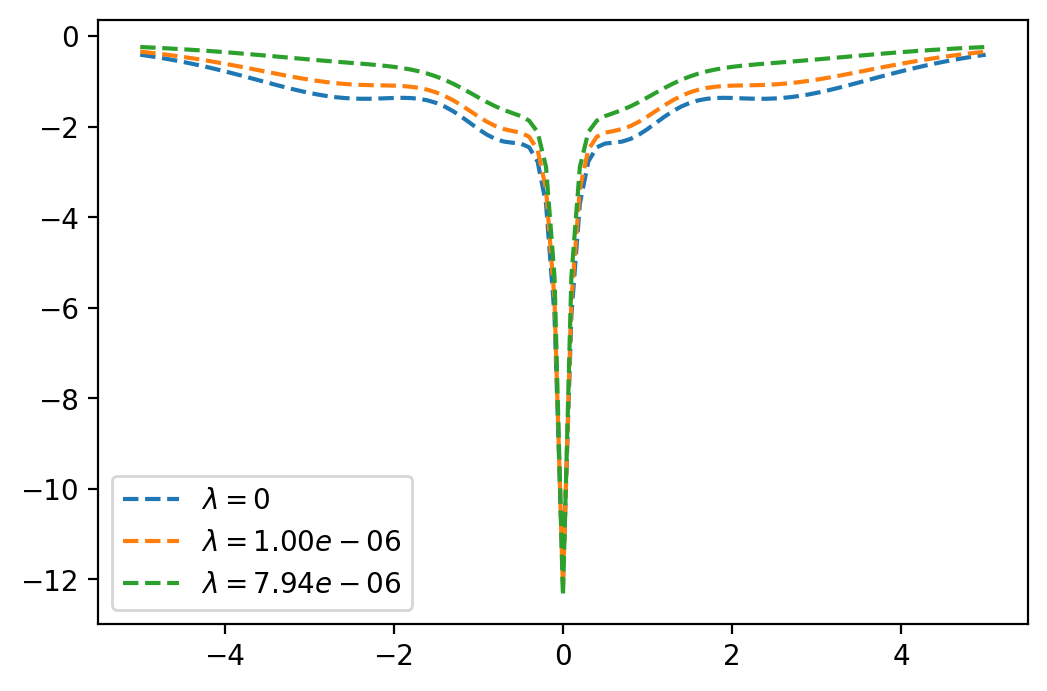

In [24]:
fig, ax = plt.subplots(dpi=200)
# ax.plot(xyz, vxc_exact, label="exact")
ax.plot(x, vxc, label="$\lambda=0$", ls='--')
ax.plot(x, vxc_P, label="$\lambda=%.2e$"%lambda_list[10], ls='--')
ax.plot(x, vxc_Ts, label="$\lambda=%.2e$"%lambda_list[7], ls='--')
ax.legend()